In [10]:
import os
import time
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import cv2 as cv

from pathlib import Path
from PIL import Image
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split

from src.data import blend
from src.models import PretrainedUNet
from src.metrics import jaccard, dice

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
unet = PretrainedUNet(
    in_channels=3,
    out_channels=2,
    batch_norm=True, 
    upscale_mode="bilinear"
).half()


In [12]:
models_folder = Path("models")
img_folder = Path("images")

In [13]:
# model_name = "hs-unet-v0.pt"
model_name = "weights_fp16.pth"
unet.load_state_dict(torch.load(models_folder / model_name))
unet.to(device)
unet.eval();

In [14]:
# torch.save(unet.state_dict(), models_folder / 'weights_fp16_second.pth')

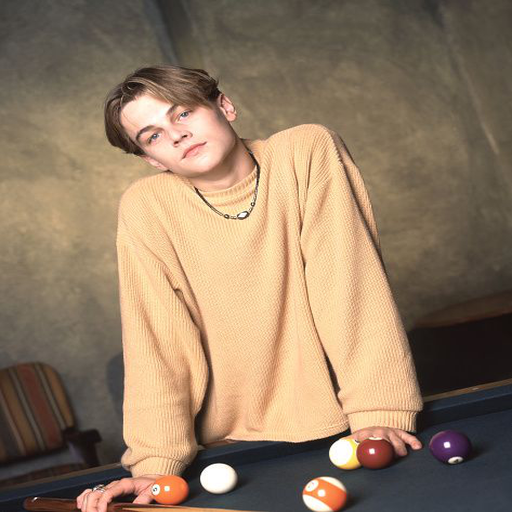

In [15]:
test_img = Image.open(img_folder / 'dicap.jpg').resize((512, 512), Image.ANTIALIAS)
torch_img = torchvision.transforms.functional.to_tensor(test_img) - 0.5
test_img

In [16]:
torch_img.shape

torch.Size([3, 512, 512])

/home/dklvch/envs/dl3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


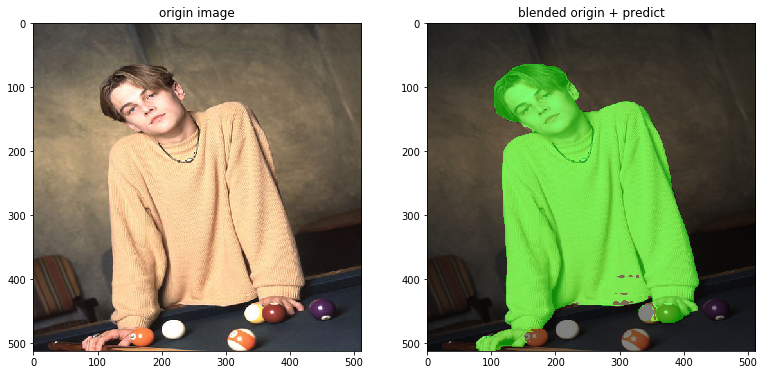

In [17]:
with torch.no_grad():
    inp = torch_img.float().to(device)
    out = unet(inp.unsqueeze(0).half())
    softmax = torch.nn.functional.log_softmax(out, dim=1)
    out = torch.argmax(softmax, dim=1)
    
#     origin = origin[0].to("cpu")
    out = out[0].to("cpu")

plt.figure(figsize=(20, 10))
pil_origin = torchvision.transforms.functional.to_pil_image(inp.cpu() + 0.5).convert("RGB")

plt.subplot(1, 3, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 3, 2)
plt.title("blended origin + predict")
plt.imshow(np.array(blend(inp.cpu() + 0.5, out)));
# plt.savefig(images_folder / "ssa-building-segmantation-4.png")

# plt.subplot(1, 3, 3)
# plt.title("blended origin + predict + mask")
# plt.imshow(np.array(blend(torch_img.cpu() + 0.5, out, out)));

In [18]:
with torch.no_grad():
    t1 = time.time()
    for i in range(100):
        inp = torch_img.float().half().to(device)
        out = unet(inp.unsqueeze(0))
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
    print(f'FPS: {100/ (time.time()-t1)}')
    out = out[0].to("cpu")
    


FPS: 21.27008607117244


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])